In [1]:
# Building deep learning models and accessing pre trained model
import tensorflow as tf 
from tensorflow import keras 
import tensorflow_hub as hub 
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from sklearn.metrics import classification_report

# For visualizations
import matplotlib.pyplot as plt
import matplotlib.image as img
import PIL.Image as Image
import cv2

import os
import numpy as np
import pathlib
import opendatasets as od
import warnings
warnings.filterwarnings('ignore')

od.download("https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset")

In [2]:
data_dir = "./rice-image-dataset/Rice_Image_Dataset" 
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('rice-image-dataset/Rice_Image_Dataset')

In [3]:
arborio = list(data_dir.glob('Arborio/*'))[:600]
basmati = list(data_dir.glob('Basmati/*'))[:600]
ipsala = list(data_dir.glob('Ipsala/*'))[:600]
jasmine = list(data_dir.glob('Jasmine/*'))[:600]
karacadag = list(data_dir.glob('Karacadag/*'))[:600]

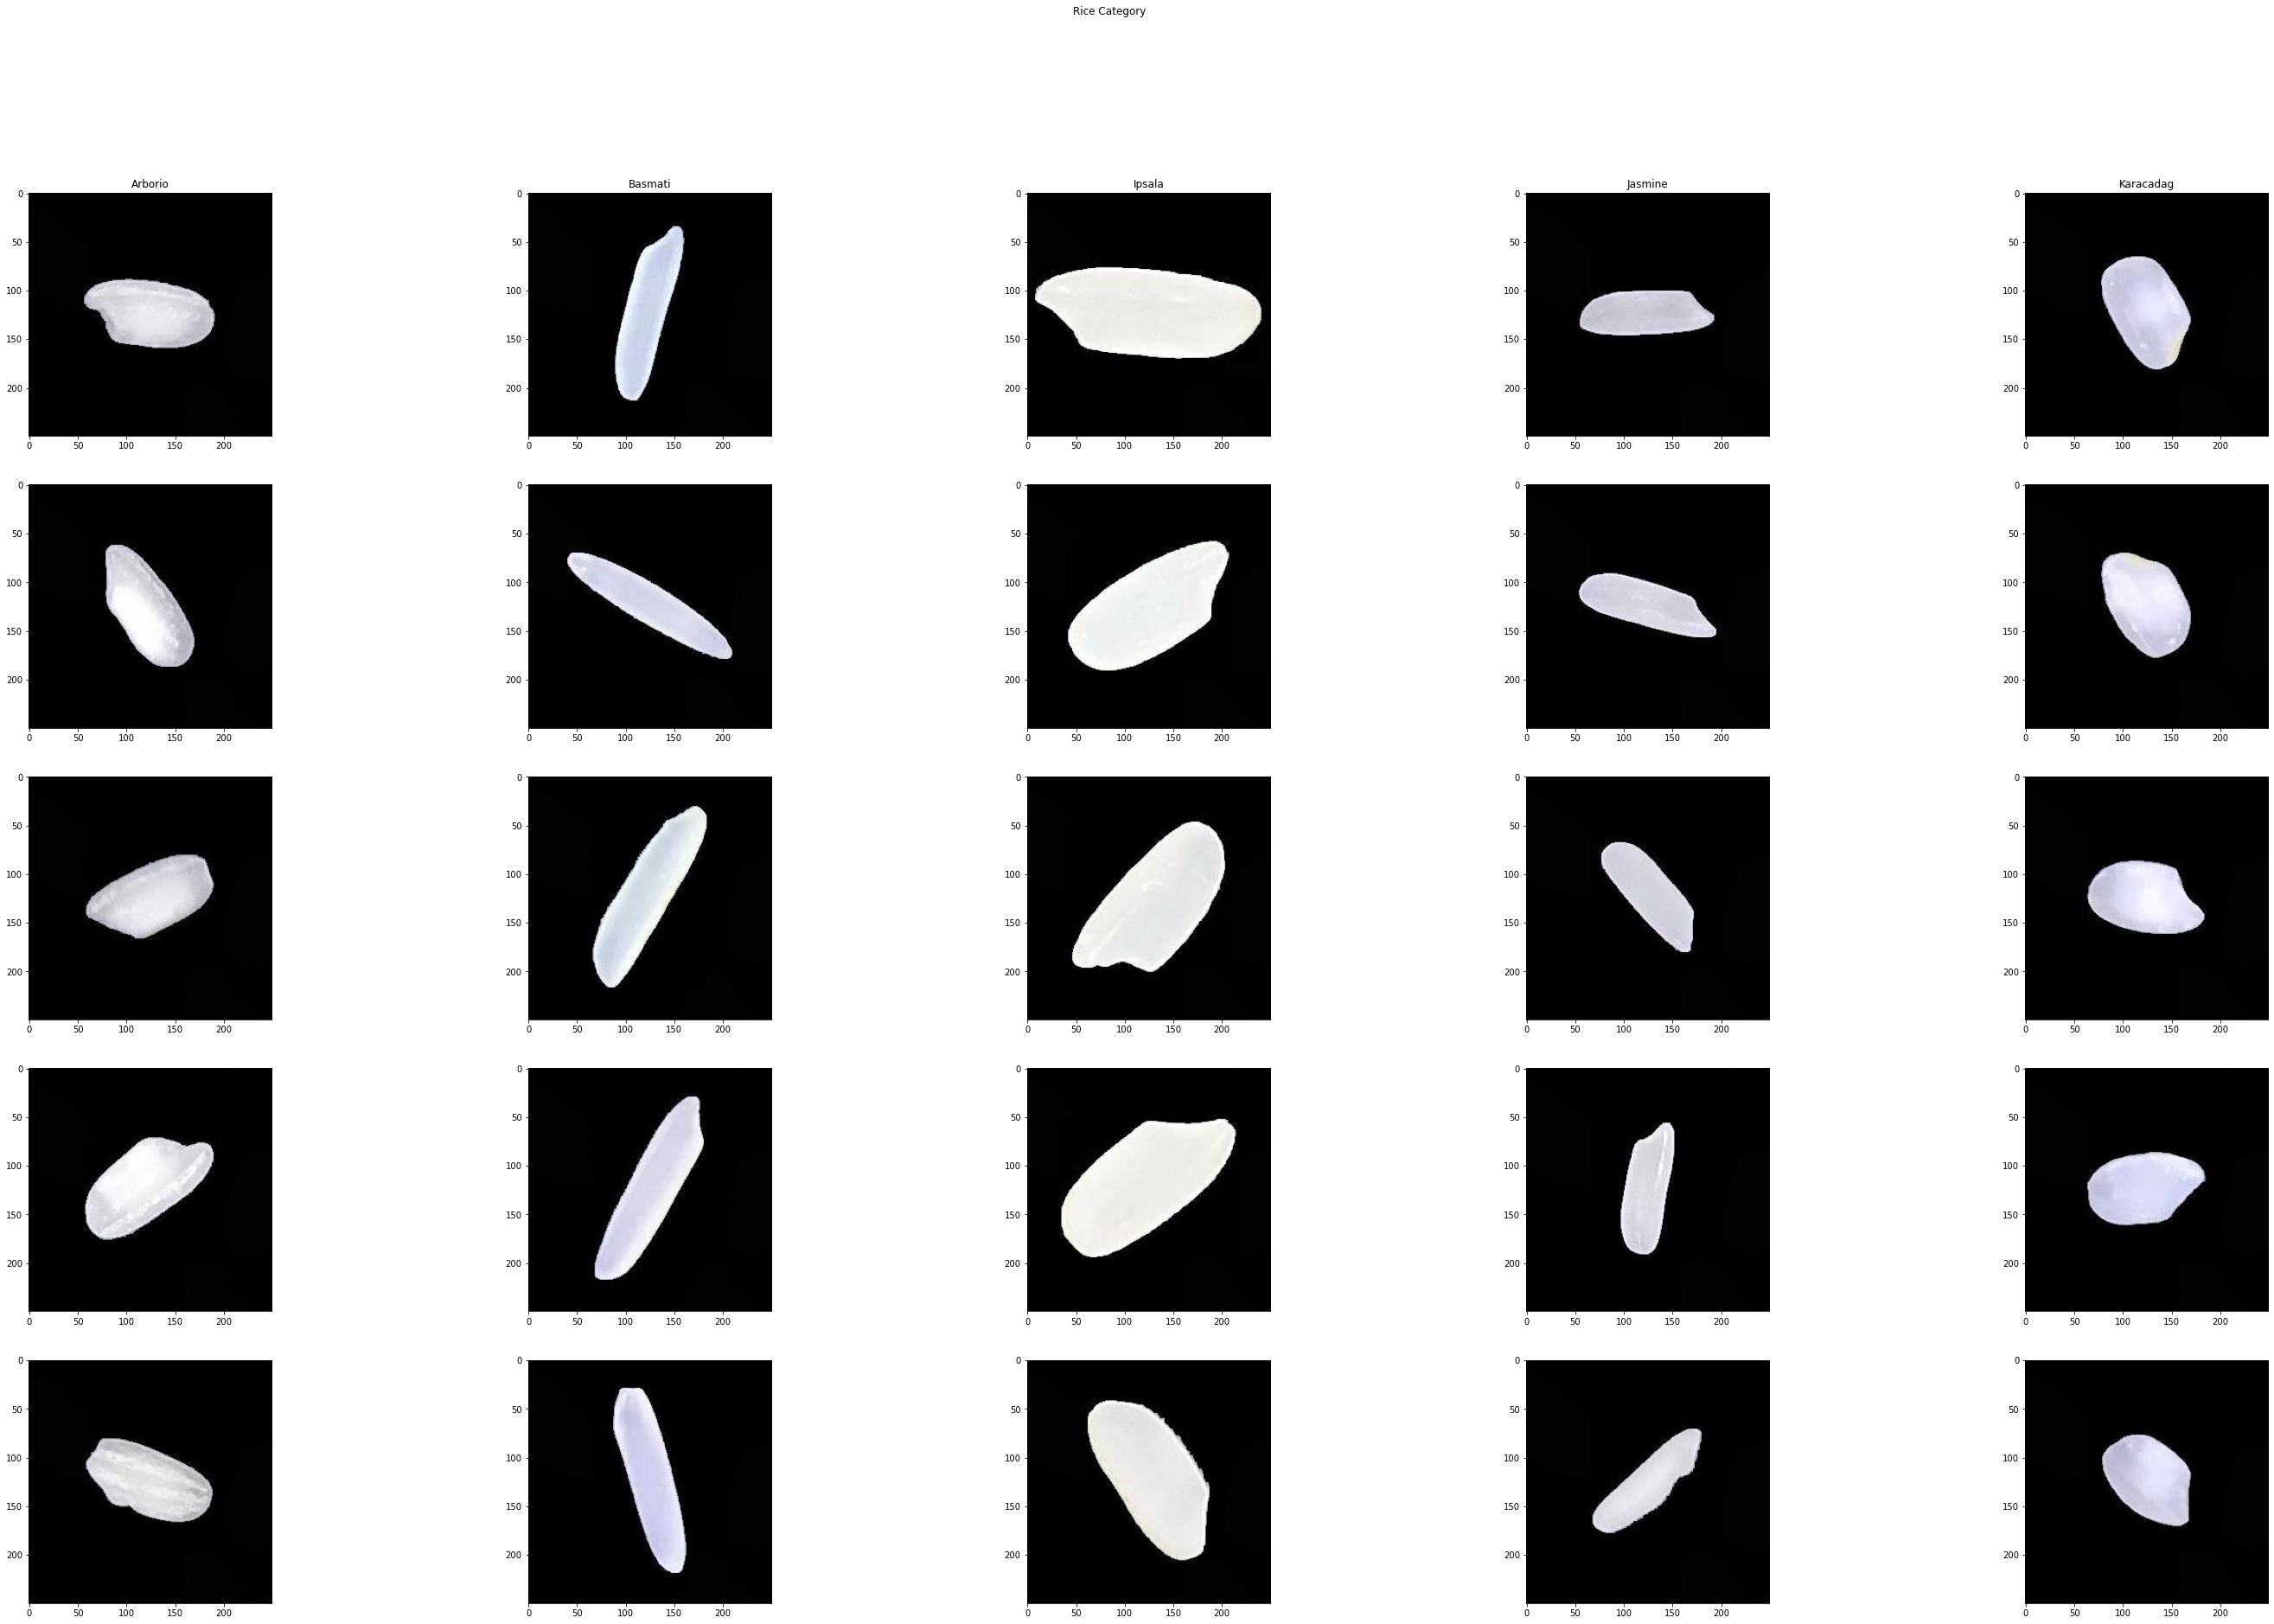

In [4]:
# plot the first images of each rice type 
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(50,30))
fig.suptitle('Rice Category')

for i in range(5):
    arborio_image = img.imread(arborio[i])
    basmati_image = img.imread(basmati[i])
    ipsala_image = img.imread(ipsala[i])
    jasmine_image = img.imread(jasmine[i])
    karacadag_image = img.imread(karacadag[i])

    ax[0,0].set_title('Arborio')
    ax[0,1].set_title('Basmati')
    ax[0,2].set_title('Ipsala')
    ax[0,3].set_title('Jasmine')
    ax[0,4].set_title('Karacadag')

    ax[i,0].imshow(arborio_image)
    ax[i,1].imshow(basmati_image)
    ax[i,2].imshow(ipsala_image)
    ax[i,3].imshow(jasmine_image)
    ax[i,4].imshow(karacadag_image)

Create a dictionary for images and labels 

In [5]:
# Images with the path
df_images = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}

# Labels for the categories (Convert str labels to numerical labels)
df_labels = {
    'arborio' : 0,
    'basmati' : 1,
    'ipsala' : 2,
    'jasmine' : 3,
    'karacadag': 4
}

# Load images (X) and labels (y) and reshape into 224x224x3 for MobileNetv2 model

X, y = [], [] 
for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) # Resizing the images to be able to pass on MobileNetv2 model
        X.append(resized_img) 
        y.append(df_labels[label])
        


In [6]:
# standardizing and split data into train, test and validation 
X = np.array(X)
X = X/255
y = np.array(y)

# 0.75 training data, 0.1875 testing data, 0.0625 validation data 

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

In [7]:
# ImageNet VGG16 

vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

# MobileNetV2
mobile_net = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4' # MobileNetv4 link
mobile_net = hub.KerasLayer(
        mobile_net, input_shape=(224,224, 3), trainable=False) # Removing the last layer

In [8]:
num_label = 5 # number of labels

for layer in vgg.layers:
    layer.trainable = False #no training of existing weights

# configure last layer of VGG
last_output = vgg.output
norm = BatchNormalization()(last_output)
x = Dropout(0.5)(norm)
flat = Flatten()(x) # Flattening the output from the previous layer
pred = Dense(num_label, activation='softmax', name='softmax')(flat) #Positive or Negative

VGG_model = Model(inputs=vgg.input, outputs=pred) # concatenates the layers
VGG_model.layers[-num_label:-1]

In [9]:
# Configure last layer of MobileNet

mobnet_model = keras.Sequential([
    mobile_net,
    keras.layers.Dense(num_label)
])

mobnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
# VGG model training 
VGG_model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


VGG_history = VGG_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))


Epoch 1/5
71/71 [==============================] - 709s 10s/step - loss: 0.2625 - acc: 0.9160 - val_loss: 0.5052 - val_acc: 0.7287
Epoch 2/5
71/71 [==============================] - 665s 9s/step - loss: 0.0555 - acc: 0.9827 - val_loss: 0.1871 - val_acc: 0.9362
Epoch 3/5
71/71 [==============================] - 698s 10s/step - loss: 0.0479 - acc: 0.9858 - val_loss: 0.0815 - val_acc: 0.9840
Epoch 4/5
71/71 [==============================] - 774s 11s/step - loss: 0.0550 - acc: 0.9822 - val_loss: 0.0754 - val_acc: 0.9734
Epoch 5/5
71/71 [==============================] - 761s 11s/step - loss: 0.0169 - acc: 0.9942 - val_loss: 0.1418 - val_acc: 0.9840


In [12]:
# MobileNet model training 
mobnet_model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

mobnet_history = mobnet_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
71/71 [==============================] - 53s 622ms/step - loss: 0.5126 - acc: 0.8520 - val_loss: 0.1933 - val_acc: 0.9574
Epoch 2/5
71/71 [==============================] - 43s 604ms/step - loss: 0.1367 - acc: 0.9747 - val_loss: 0.1274 - val_acc: 0.9734
Epoch 3/5
71/71 [==============================] - 43s 604ms/step - loss: 0.0955 - acc: 0.9822 - val_loss: 0.1197 - val_acc: 0.9681
Epoch 4/5
71/71 [==============================] - 42s 599ms/step - loss: 0.0747 - acc: 0.9871 - val_loss: 0.0901 - val_acc: 0.9787
Epoch 5/5
71/71 [==============================] - 47s 669ms/step - loss: 0.0635 - acc: 0.9880 - val_loss: 0.0845 - val_acc: 0.9787


In [13]:
# VGG model evaluation 
VGG_model.evaluate(X_test,y_test)

y_pred = VGG_model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

9/9 [==============================] - 170s 18s/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       118
           1       1.00      0.97      0.98       115
           2       1.00      1.00      1.00       115
           3       0.97      1.00      0.98       115
           4       0.99      1.00      0.99        99

    accuracy                           0.99       562
   macro avg       0.99      0.99      0.99       562
weighted avg       0.99      0.99      0.99       562



In [14]:
# MobileNet model evaluation
mobnet_model.evaluate(X_test,y_test)

y_pred = mobnet_model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

9/9 [==============================] - 17s 2s/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       118
           1       1.00      0.97      0.99       115
           2       1.00      1.00      1.00       115
           3       0.95      1.00      0.97       115
           4       0.98      0.98      0.98        99

    accuracy                           0.98       562
   macro avg       0.98      0.98      0.98       562
weighted avg       0.98      0.98      0.98       562



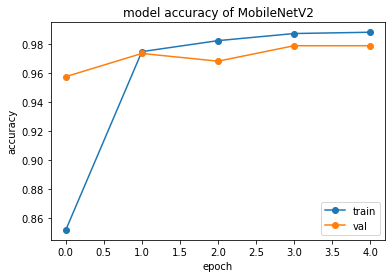

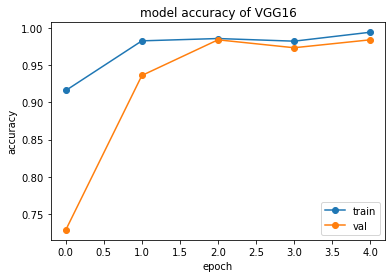

In [15]:
# model accuracy visualization 

plt.plot(mobnet_history.history['acc'], marker='o')
plt.plot(mobnet_history.history['val_acc'], marker='o')
plt.title('model accuracy of MobileNetV2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# model accuracy visualization 

plt.plot(VGG_history.history['acc'], marker='o')
plt.plot(VGG_history.history['val_acc'], marker='o')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()



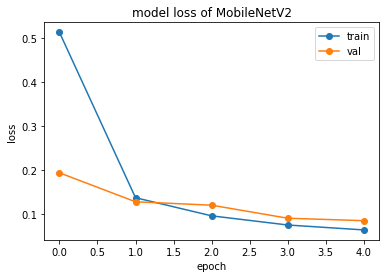

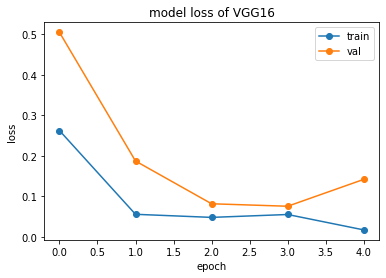

In [16]:
# model loss every epochs 

plt.plot(mobnet_history.history['loss'], marker='o')
plt.plot(mobnet_history.history['val_loss'], marker='o')
plt.title('model loss of MobileNetV2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


plt.plot(VGG_history.history['loss'], marker='o')
plt.plot(VGG_history.history['val_loss'], marker='o')
plt.title('model loss of VGG16')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()